# Introduction
As of 2025-06-12, the volunteers at rangers.urbanrivers have added 59,351 observations.  
These observations are not error-proof, but they are definitely a useful means of creating base-truth casses for image labeling.  

This notebook serves as a means of aggregating those data from the server api in a scaleable manner - to where as observations continue to grow, we can ingest new labels for model improvement


In [1]:
# Data Handling
import pandas as pd

# IO - getting files and images
from kaggle_secrets import UserSecretsClient
import requests
import json
import os
import urllib.parse

# For randomizing which images get downloaded
import random
from tqdm.auto import tqdm

# For model loading and fine tuning
from fastai.vision.all import *
import torch

print("==== Loaded Libraries ====")

==== Loaded Libraries ====


# Accessing observations (image labels) from the public api
Today we're going to use the api - a better means of accessing these data would be a direct connection to the production server.  
We need the public mongo server URI and credentials for this - then we can use pymongo (MongoClient) with:  
```python
client = MongoClient'mongo_uri')
db = client['db_string']
collection = db['collection_string']
data = list(collection.aggregate( [ .... ] )
```

Again though, for now let's use what we have.

In [2]:
%%time
# Define the list of species we are going to pull
species_list = [
    "Canis latrans", "Canis familiaris", "Felis catus", "Castor canadensis",
    "Ondatra zibethicus", "Sylvilagus floridanus", "Sciurus carolinensis",
    "Procyon lotor", "Lontra canadensis", "Didelphis virginiana",
    "Anas platyrhynchos", "Branta canadensis", "Trachemys scripta elegans",
    "Chelydra serpentina", "Chrysemys picta", "Apalone spinifera",
    "Columba livia", "Sturnus vulgaris", "Agelaius phoeniceus",
    "Passer domesticus", "Turdus migratorius", "Corvus brachyrhynchos",
    "Ardea herodias", "Nycticorax nycticorax", "Astur cooperii",
    "Actitis macularius", "Aix sponsa", "Ardea alba", "Cardinalis cardinalis",
    "Cyprinus carpio"
]
species_encoded = ",".join([urllib.parse.quote(s) for s in species_list])

# Get URLs for organising download links
user_secrets = UserSecretsClient()
obs_url = user_secrets.get_secret("OBS_BASE")

# API will timeout if there are too many returned, so we'll pageinate in batches of 1000
def fetch_all_obs():
    batch_size = 1000
    page = 1
    all_images = []


    while True:
        url = f"{obs_url}?species={species_encoded}&limit={batch_size}&page={page}"
        
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Request failed at page {page} with status code {response.status_code}")
            break

        data = response.json()
        images = data.get("images", [])
        if not images:
            # No more images left
            break

        all_images.extend(images)
        print(f"Page {page}: Retrieved {len(images)} image observations")
        page += 1

    return all_images


# Fetch JSON for all images
try:
    print("===== Starting JSON Fetch =====")
    obs_json = fetch_all_obs()
except Exception as e:
    print(f"Problem with fetch: {e}")
else:
    print("===== Completed JSON Fetch =====")


===== Starting JSON Fetch =====
Page 1: Retrieved 1000 image observations
Page 2: Retrieved 1000 image observations
Page 3: Retrieved 1000 image observations
Page 4: Retrieved 1000 image observations
Page 5: Retrieved 1000 image observations
Page 6: Retrieved 1000 image observations
Page 7: Retrieved 1000 image observations
Page 8: Retrieved 1000 image observations
Page 9: Retrieved 1000 image observations
Page 10: Retrieved 1000 image observations
Page 11: Retrieved 1000 image observations
Page 12: Retrieved 1000 image observations
Page 13: Retrieved 118 image observations
===== Completed JSON Fetch =====
CPU times: user 785 ms, sys: 142 ms, total: 928 ms
Wall time: 50.6 s


## Process the returned JSON for the fields we need
We're looking for the `mediaID` (our primary key),  
The `publicURL` that we can use to download the image,  
The `scientificName` that observers have selected and the `observationCount` of times that people have agreed on the species.  
  -  Note this is different than a similar field `count` that represents the number of species in the photo
  -  An `observationCount` increase requires both the species and the `count` to be the same.
  -  For example, a `count` of 1 canis familiaris with a `observationCount` of 1 could also have a `count` of 2 and `observationCount` of 3 if 3 people saw 2 dogs, and 1 person saw 1 dog.
  -  In version 5 we include the count

In [3]:
%%time
# Process the JSON
def process_obs_json(obs):
    records = []
    for ob in obs:
        media_id = ob.get("mediaID")
        public_url = ob.get("publicURL")
        for species in ob.get("speciesConsensus", []):
            scientific_name = species.get("scientificName")
            observation_count = species.get("observationCount")
            species_count = species.get("count") 
            records.append({
                "mediaID": media_id,
                "publicURL": public_url,
                "scientificName": scientific_name,
                "observationCount": observation_count,
                "speciesCount": species_count
            })
    df = pd.DataFrame(records)

    return df

df = process_obs_json(obs_json)

with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df.head())

print(len(df))

,mediaID,publicURL,scientificName,observationCount,speciesCount
0,9189635ca915cb3507c37f0b4c529846,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0158.JPG,Canis familiaris,1,1
1,9189635ca915cb3507c37f0b4c529846,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0158.JPG,None,2,1
2,9a6f3bbe7d62565c2ce5b632c0dfad55,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0160.JPG,Canis familiaris,1,1
3,9a6f3bbe7d62565c2ce5b632c0dfad55,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0160.JPG,None,2,1
4,ae560a001909c62e2993a1d2aa09c182,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0170.JPG,Canis familiaris,1,1


18012
CPU times: user 50.7 ms, sys: 3.94 ms, total: 54.7 ms
Wall time: 59.6 ms


## Save data as we go along for referencing later as needed
We're going to 'checkpoint' a few files while filtering because we might go back or try different types of classification or detection later


In [4]:
# Save the processed data as is
os.makedirs('/kaggle/working/data', exist_ok=True)
df.to_csv('/kaggle/working/data/initial_processed_data.csv', index=False)
df = pd.read_csv("/kaggle/working/data/initial_processed_data.csv")
print("\n==== Saved checkpoint 1 ====\n")


==== Saved checkpoint 1 ====



# Data Cleaning and Filtering
The raw data from the observations could have a few issues:  
Duplication - if there are bugs in the observation recording process
False positives - if people classify the wrong species in an image, or accidentally classify multiple when there is only one
False negatives - from time to time, people could be classifying long groups of blanks, and then accidentally skip an image with an animal

In [5]:
# Solve the potential duplicates for every image and observation - just want a validated list
df2 = df.drop_duplicates().reset_index(drop=True)
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df2.head())

print(f'Total rows: {len(df2)}\n')
print(df2['scientificName'].value_counts())

,mediaID,publicURL,scientificName,observationCount,speciesCount
0,9189635ca915cb3507c37f0b4c529846,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0158.JPG,Canis familiaris,1,1
1,9189635ca915cb3507c37f0b4c529846,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0158.JPG,NaN,2,1
2,9a6f3bbe7d62565c2ce5b632c0dfad55,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0160.JPG,Canis familiaris,1,1
3,9a6f3bbe7d62565c2ce5b632c0dfad55,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0160.JPG,NaN,2,1
4,ae560a001909c62e2993a1d2aa09c182,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0170.JPG,Canis familiaris,1,1


Total rows: 17990

scientificName
Branta canadensis            4300
Anas platyrhynchos           3407
Trachemys scripta elegans    2244
Apalone spinifera            1290
Actitis macularius           1121
                             ... 
Marmota monax                   1
Leporidae                       1
Actinopterygii                  1
Castorimorpha                   1
Ictaluridae                     1
Name: count, Length: 87, dtype: int64


## Counts vs ObsCounts
In version 5 of this notebook we added speciesCount - When deduplicating, now if there are votes for 1x and 2x of a species, there are potentially new rows.  
We'll maintain a minimum vote requirement of 3 - this should reduce times where only 1 or 2 people have voted incorrectly.

In [6]:
# Filter to species with at least 3 votes
df3 = df2[(df2['observationCount'] >= 3) ]
df3.loc[:, 'scientificName'] = df3['scientificName'].fillna("blank")
df3 = df3.sort_values(by='observationCount', ascending=False).reset_index(drop=True)
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df3.head())

print(f'Total rows: {len(df3)}\n')
print(df3['scientificName'].value_counts())

,mediaID,publicURL,scientificName,observationCount,speciesCount
0,ff2c1b7718fd23de7d4f13086aa94fa3,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW2126.JPG,blank,10,1
1,2b38de3083349c8aafce8b6d66bb7aeb,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW2954.JPG,Castor canadensis,9,1
2,f4e25c036a53d2d204de57c5fd3ce782,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW2953.JPG,Castor canadensis,9,1
3,eae1c8e369ca98c1fde6961ce1389f68,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW2128.JPG,blank,9,1
4,8a95a3db6dac5ec39a1d7d4d3866b694,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW2955.JPG,Castor canadensis,9,1


Total rows: 1801

scientificName
Branta canadensis            626
blank                        228
Anas platyrhynchos           223
Actitis macularius           213
Canis familiaris             144
Trachemys scripta elegans    143
Castor canadensis             70
Apalone spinifera             35
Turdus migratorius            29
Sylvilagus floridanus         28
Ondatra zibethicus            13
Procyon lotor                 11
Passer domesticus             11
Ardea herodias                11
Nycticorax nycticorax          4
Spizelloides arborea           3
Sturnus vulgaris               3
Larus delawarensis             2
Quiscalus quiscula             1
Fulica americana               1
Rattus norvegicus              1
Aves                           1
Name: count, dtype: int64


You can tell now that our value_counts report is showing the full list of species because some more rare species haven't been confirmed by at least 3 people.  

## Identifying multiple classification images vs single classification
Animals share spaces.  
As long as there isn't animosity, it's very possible that some images have more than one species -  
For the purpose of model type, we need to delineate what we're fine-tuning to, so it's important to group and understand the nature of each image from the observations.

### Dropping speciesCount while grouping
The group by below directly references mediaID and publicURL - this effectively collapses the potential for images with 1 count of a species together with multiple counts.  
Another options here would be to include the speciesCount in the group by if we wanted to start classifying the number in addition to the type in images (we don't for now).  
ex:  
`df3_grouped = df3.groupby(['mediaID', 'publicURL', 'speciesCount'])['scientificName'] \ ...`

In [7]:
# This might be a multiple classification problem - let's see if things change when we group by and list the scientific names
df3_grouped = df3.groupby(['mediaID', 'publicURL'])['scientificName'] \
    .agg(lambda x: ';'.join(sorted(set(x)))) \
    .reset_index()

# To keep classes where only blank and yet not ones containing blank
def is_only_blank(label_str):
    return label_str.strip() == "blank"

# Filter: keep rows where "blank" is not in the list OR is the only label
# This is because sometimes people are categorizing multiple blanks in a row and do not see the animal while zoned out.
df3_grouped = df3_grouped[
    ~df3_grouped['scientificName'].str.contains(';blank') |
    df3_grouped['scientificName'].apply(is_only_blank)
]

# Show the results
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df3_grouped.head())
    
print(f'Total rows: {len(df3_grouped)}\n')
print(df3_grouped['scientificName'].value_counts())

,mediaID,publicURL,scientificName
0,0017307382475a160ccf074bf437115b,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-27_UR011/DCIM/100MEDIA/SYFW0781.JPG,Anas platyrhynchos;Branta canadensis
1,002fe9a5dc3a1bf6b14298838bae6982,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/101SYCAM/SYEW0819.JPG,Branta canadensis
2,0032759e5c6eb2df7b23b58e9c68f59c,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW3154.JPG,Actitis macularius
3,00bafc77dcb4d686a46e181ea50d3104,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW1550.JPG,blank
4,00bcb26cd24bd4dce3f2f47f848faf63,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW7278.JPG,Branta canadensis


Total rows: 1379

scientificName
Branta canadensis                                                 556
Anas platyrhynchos                                                166
Actitis macularius                                                159
blank                                                             101
Trachemys scripta elegans                                          56
Actitis macularius;Trachemys scripta elegans                       51
Castor canadensis                                                  48
Anas platyrhynchos;Branta canadensis                               40
Turdus migratorius                                                 29
Sylvilagus floridanus                                              27
Canis familiaris                                                   26
Apalone spinifera;Trachemys scripta elegans                        18
Ondatra zibethicus                                                 11
Passer domesticus                                        

In [8]:
# Save the filtered df as a starting point for image requests and multiclassification future decisions
df3_grouped.to_csv("/kaggle/working/data/all_labeled_species_urls.csv", index=False)
print("\n==== Saved checkpoint 2 ====\n")


==== Saved checkpoint 2 ====



### As of 2025-06-13 there are 1379 rows for the 36 classifications

There are a few that are classified as multiple species - for now, let's focus on those that are just single labeled.

In [9]:
# We're going to focus on single species labeled images and blanks for an attempt at training a simple classification model - a scientific name always has at least one space - so we'll filter one last time.
df4 = df3_grouped[(~df3_grouped["scientificName"].str.contains(";")) & (df3_grouped["scientificName"].str.contains(" ")) | (df3_grouped["scientificName"] == 'blank')]

# Show the results
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df4.head())
    
print(f'Total rows: {len(df4)}\n')
print(df4['scientificName'].value_counts())

,mediaID,publicURL,scientificName
1,002fe9a5dc3a1bf6b14298838bae6982,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/101SYCAM/SYEW0819.JPG,Branta canadensis
2,0032759e5c6eb2df7b23b58e9c68f59c,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW3154.JPG,Actitis macularius
3,00bafc77dcb4d686a46e181ea50d3104,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW1550.JPG,blank
4,00bcb26cd24bd4dce3f2f47f848faf63,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW7278.JPG,Branta canadensis
5,00f02cfbbb34ec0ba7be807729a1af13,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-27_UR011/DCIM/101MEDIA/SYFW0304.JPG,Anas platyrhynchos


Total rows: 1228

scientificName
Branta canadensis            556
Anas platyrhynchos           166
Actitis macularius           159
blank                        101
Trachemys scripta elegans     56
Castor canadensis             48
Turdus migratorius            29
Sylvilagus floridanus         27
Canis familiaris              26
Ondatra zibethicus            11
Passer domesticus             10
Procyon lotor                 10
Ardea herodias                 9
Apalone spinifera              6
Nycticorax nycticorax          4
Sturnus vulgaris               3
Spizelloides arborea           3
Quiscalus quiscula             1
Fulica americana               1
Larus delawarensis             1
Rattus norvegicus              1
Name: count, dtype: int64


## Single species type in image subset - 
### As of 2025-06-13 there are 1228 rows for 21 classified species
There are some more rare species than others.  

Branta canadensis - the canadian goose - there are 556 images exist of that classification today, where..  
Castor canadensis - the beaver - only has 48 and ..  
Nycticorax nycticorax - the Night Heron - only has 4 (but we do have a lot of them in photos)  

Part of this is because people don't recognize some speces - lumping them into a higher taxonomic class, like 'aves'.  
For the purpose of having a good number of images for training we need to set a minimum threshold.  

For right now, we're going to use 26, but realistic production models might need more like 200.  
The decision to allow at least 26 is to have more classes for fine-tuning and testing:  
25 for training with a 20% validation (5 of 25) and 1 for testing later.

## Set a minimum number of observations so our model has some chance at learning

In [10]:
# Adjust as the project progresses:
n_obs_minimum = 26

In [11]:
# Filter current df to where the minimum is met
species_counts = df4['scientificName'].value_counts()
species_to_keep = species_counts[species_counts > n_obs_minimum].index

df5 = df4[df4['scientificName'].isin(species_to_keep)]

# Show the results
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df5.head())
    
print(f'Total rows: {len(df5)}\n')
print(df5['scientificName'].value_counts())

,mediaID,publicURL,scientificName
1,002fe9a5dc3a1bf6b14298838bae6982,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/101SYCAM/SYEW0819.JPG,Branta canadensis
2,0032759e5c6eb2df7b23b58e9c68f59c,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW3154.JPG,Actitis macularius
3,00bafc77dcb4d686a46e181ea50d3104,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW1550.JPG,blank
4,00bcb26cd24bd4dce3f2f47f848faf63,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW7278.JPG,Branta canadensis
5,00f02cfbbb34ec0ba7be807729a1af13,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-27_UR011/DCIM/101MEDIA/SYFW0304.JPG,Anas platyrhynchos


Total rows: 1142

scientificName
Branta canadensis            556
Anas platyrhynchos           166
Actitis macularius           159
blank                        101
Trachemys scripta elegans     56
Castor canadensis             48
Turdus migratorius            29
Sylvilagus floridanus         27
Name: count, dtype: int64


### We're left with 1142 rows for 8 classifications

In [12]:
# save the single species images with at least n observations as a data checkpoint
df5.to_csv(f'/kaggle/working/data/species_over{n_obs_minimum}.csv', index=False)
print("\n==== Saved checkpoint 3 ====\n")


==== Saved checkpoint 3 ====



# Downloading Images that meet the criteria
Passing our filtered df to the s3 bucket to request images in grouped train or test splits

In [13]:
# Select the df cleaning state we want to use
df = df5

# Create the directories
base_dir = '/kaggle/working/images'
test_dir = '/kaggle/working/_tests'
os.makedirs(test_dir, exist_ok=True)

# Shuffle the whole DataFrame first to ensure randomness
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
grouped = list(df_shuffled.groupby('scientificName'))

In [14]:
# Show the structure of the grouped list for understanding
print("speciesName: ", grouped[0][0])
print("dataframe: ")
grouped[0][1].head()

speciesName:  Actitis macularius
dataframe: 


,mediaID,publicURL,scientificName
5,b13837e9d58ba235ed79797c4df76fc6,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW3228.JPG,Actitis macularius
13,ae461ab4352ef09a4211d7449a4cce3c,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-27_UR011/DCIM/101MEDIA/SYFW1960.JPG,Actitis macularius
35,05048cd3bff653c1b1d573857dc827f9,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-27_UR011/DCIM/101MEDIA/SYFW0197.JPG,Actitis macularius
36,53c055e17c2c389f3c33680a80ae1b73,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-27_UR011/DCIM/101MEDIA/SYFW0162.JPG,Actitis macularius
42,169887393eeb16f9d8dba5e59d435793,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW3202.JPG,Actitis macularius


## Grouped is a list where each index species has a dataframe  so key, value is scientific_name, df of images

/kaggle/working/images/Actitis_macularius/b13837e9d58ba235ed79797c4df76fc6.jpg


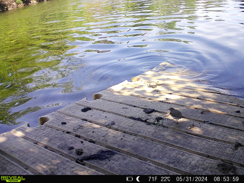

In [15]:
# fast ai version of image downloading
from fastdownload import download_url

ims = grouped[0][1]['publicURL'].tolist()
imn = grouped[0][1]['mediaID'].tolist()

len(ims)

dest = os.path.join(base_dir, grouped[0][0].replace(' ','_'), f'{imn[0]}.jpg')
print(dest)

download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(244,244)

In [16]:
# For cleanup while testing
!rm /kaggle/working/images/* -rf

In [17]:
%%time
# fast ai version of all images downloading - drops the mediaID from the pipeline which might be ok
for species, group in grouped:
    group = group.dropna(subset=['publicURL'])
    if len(group) < n_obs_minimum:
        continue

    selected = group.sample(n=n_obs_minimum, random_state=42).reset_index(drop=True)
    n_split = n_obs_minimum - 1
    train_samples = selected.iloc[:n_split]
    test_sample = selected.iloc[n_split]

    train_urls = train_samples['publicURL'].tolist()
    test_url = test_sample['publicURL']
    
    
    species_folder = species.replace(' ', '_')
    species_dir = os.path.join(base_dir, species_folder)
    
    download_images(species_dir, urls=train_urls)
    print(species_dir)
    
    # Download test image
    test_image_path = os.path.join(test_dir, f'{species_folder}.JPG')
    download_url(test_url, test_image_path)

print("==== Downloaded Images ====")
    

/kaggle/working/images/Actitis_macularius


/kaggle/working/images/Anas_platyrhynchos


/kaggle/working/images/Branta_canadensis


/kaggle/working/images/Castor_canadensis


/kaggle/working/images/Sylvilagus_floridanus


/kaggle/working/images/Trachemys_scripta_elegans


/kaggle/working/images/Turdus_migratorius


/kaggle/working/images/blank


==== Downloaded Images ====
CPU times: user 2.47 s, sys: 1.95 s, total: 4.42 s
Wall time: 1min 9s


In [18]:
# validate images
fns = get_image_files(base_dir)
failed = verify_images(fns)
print(failed)
failed.map(Path.unlink);

[]


# For each image downloaded we are going to interact with fastai
Dataloaders (dls) are tensors that fastai simplifies for use in model fine-tuning.  
The library loads only what's needed (even though we passed * at the top) and has some built in common features.  

We're planning on using resnet18 - so we want to resize to 224x224 - and want to use aug_transforms() to get some visual variation in images from cameratraps.  
This means that at each pass of the dls to the fine tuning system the model will see slightly different images so it learns how to detect with some variation.

==== Loading images into tensors ====

CPU times: user 12.4 s, sys: 6.16 s, total: 18.6 s
Wall time: 19 s


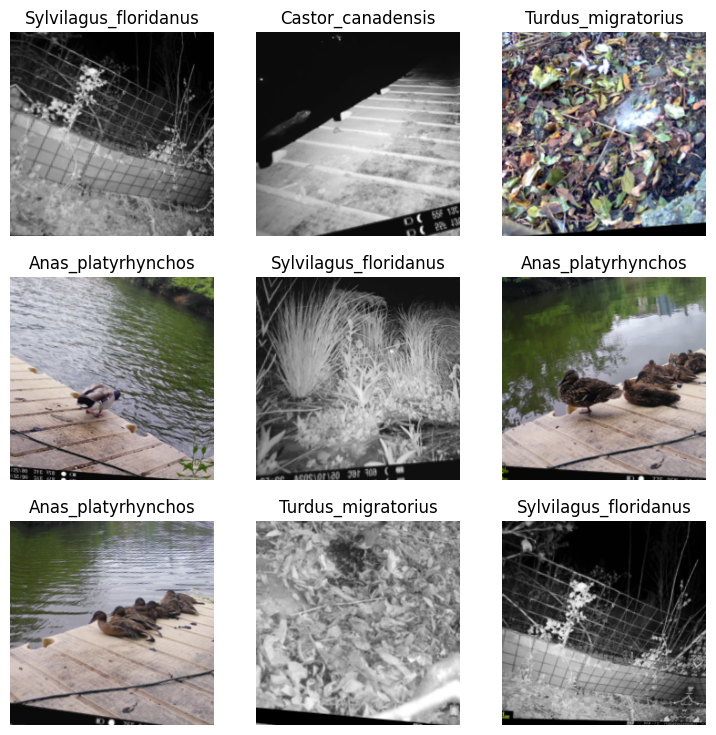

In [19]:
%%time
print('==== Loading images into tensors ====\n')
path = Path('/kaggle/working/images')

# Ignore test folder during training
dls = ImageDataLoaders.from_folder(
    path,
    train='.',       # Train data is in the species folders
    valid_pct=0.2,   # FastAI will split off a validation set
    seed=42,
    item_tfms=Resize(224),  # Resize all images to 224x224
    batch_tfms=aug_transforms(),
)

dls.show_batch(max_n=9)


Depending on how the random split happened, we might have multiple images of canadian geese at night and in black and white - searching for augmentations that include black and white conversions might be helpful.

# Fine runing resnet 18 to our classifications
Finally we'll download the resnet 18 model and apply fine tuning to our dataset.  
Images , tests, and data are organized in folders and loaded into dls as appropriate.  

In [20]:
%%time
learn = vision_learner(dls, resnet18, metrics=error_rate)

if torch.cuda.is_available():
    learn.model = learn.model.cuda()
    print("Using:", next(learn.model.parameters()).device)  # should print 'cuda:0'
else:
    learn.model = learn.model.cpu()
    print("Using CPU")

learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]


Using: cuda:0


epoch,train_loss,valid_loss,error_rate,time
0,3.732132,3.336696,0.750000,00:32


epoch,train_loss,valid_loss,error_rate,time
0,2.520442,1.997675,0.625000,00:32
1,2.092896,0.904394,0.300000,00:32
2,1.709266,0.439030,0.125000,00:31
3,1.408900,0.322387,0.100000,00:30
4,1.221253,0.293004,0.100000,00:31


CPU times: user 2.33 s, sys: 1.3 s, total: 3.63 s
Wall time: 3min 10s


## Testing a single image prediction
Here we'll look at our test for a beaver and see if the model can predict it correctly.

<Axes: title={'center': 'Probably: Castor_canadensis (0.93)'}>

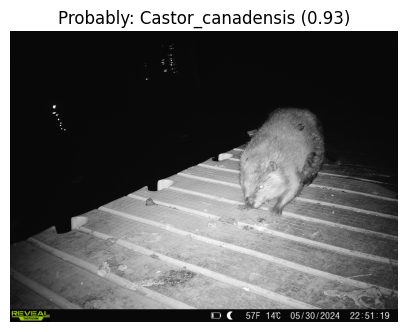

In [21]:
image_path = '/kaggle/working/_tests/Castor_canadensis.JPG'
pred, pred_idx, probs = learn.predict(PILImage.create(image_path))


PILImage.create(image_path).show(title=f"Probably: {pred} ({probs[pred_idx]:.2f})")

## Tabular predictions for all images in the folder

In [22]:
# Predicting in a table for each image
test_path = Path("/kaggle/working/_tests")
test_files = get_image_files(test_path)

results = []
for f in test_files:
    pred_class, pred_idx, pred_probs = learn.predict(f)
    results.append({
        'file': f.name,
        'pred_class': str(pred_class),
        'probability': float(pred_probs[pred_idx]),
        'top3': [
            (learn.dls.vocab[i], format(float(pred_probs[i]), ".4f"))
            for i in pred_probs.argsort(descending=True)[:3]
        ]
    })

results_df = pd.DataFrame(results)
display(results_df)

,file,pred_class,probability,top3
0,Actitis_macularius.JPG,Actitis_macularius,0.999715,"[(Actitis_macularius, 0.9997), (Anas_platyrhynchos, 0.0002), (Branta_canadensis, 0.0000)]"
1,Trachemys_scripta_elegans.JPG,Trachemys_scripta_elegans,0.998948,"[(Trachemys_scripta_elegans, 0.9989), (Anas_platyrhynchos, 0.0007), (Actitis_macularius, 0.0002)]"
2,Branta_canadensis.JPG,Branta_canadensis,0.995522,"[(Branta_canadensis, 0.9955), (Castor_canadensis, 0.0028), (Anas_platyrhynchos, 0.0005)]"
3,Turdus_migratorius.JPG,Turdus_migratorius,0.991371,"[(Turdus_migratorius, 0.9914), (Actitis_macularius, 0.0038), (Trachemys_scripta_elegans, 0.0021)]"
4,Castor_canadensis.JPG,Castor_canadensis,0.926573,"[(Castor_canadensis, 0.9266), (Sylvilagus_floridanus, 0.0286), (Branta_canadensis, 0.0154)]"
5,Anas_platyrhynchos.JPG,Branta_canadensis,0.533733,"[(Branta_canadensis, 0.5337), (blank, 0.2012), (Actitis_macularius, 0.1294)]"
6,Sylvilagus_floridanus.JPG,Sylvilagus_floridanus,0.999965,"[(Sylvilagus_floridanus, 1.0000), (Actitis_macularius, 0.0000), (Branta_canadensis, 0.0000)]"
7,blank.JPG,Turdus_migratorius,0.776000,"[(Turdus_migratorius, 0.7760), (Trachemys_scripta_elegans, 0.0815), (Castor_canadensis, 0.0416)]"


## A pretty prediction plot for 9 of the test images

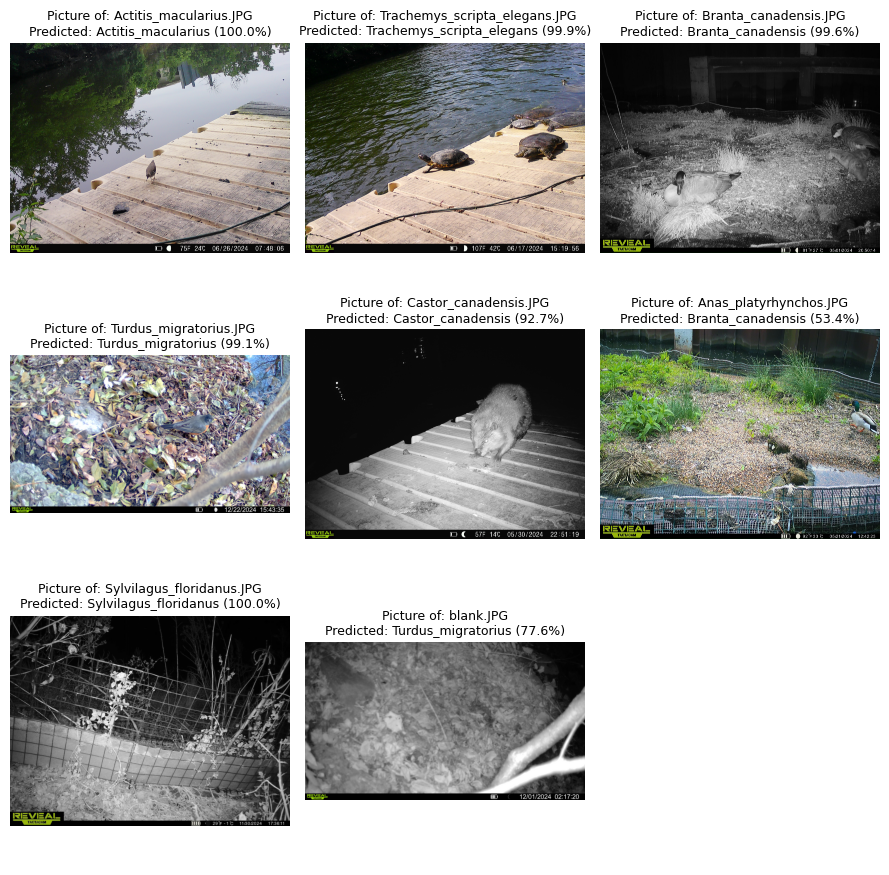

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for ax, img_file in zip(axes, test_files):
    img = PILImage.create(img_file)
    pred_class, pred_idx, pred_probs = learn.predict(img)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Picture of: {img_file.name}\nPredicted: {pred_class} ({pred_probs[pred_idx]:.1%})", fontsize=9)

# Hide unused subplots if fewer than 9 images
for ax in axes[len(test_files):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Exporting the fine tuned model

In [24]:
# export the model for futher use
learn.export('/kaggle/working/2025-06-13-res18x25p-v6.pkl')